# QMCF solver

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm, svd, pinv
from scipy import io
import networkx as nx

In [155]:
E = np.array([[-1, -1, -1, 0, 0, 0], [1, 0, 0, -1, -1, 0], [0, 1, 0, 1, 0, -1], [0, 0, 1, 0, 1, 1]])
b = np.array([-10, 0, 0, 10])
u = np.array([10, 10, 10, 10, 10, 10])
q = np.array([4, 4, 4, 10, 2, 2])
Q = np.array([199, 100, 113, 105, 135, 145])

In [59]:
n = E.shape[1]
m = E.shape[0]

In [50]:
edges = []
# iterate by column
for i in range(n):
    # get node index of current edge
    node_index = E[:,i].nonzero()[0]
    # get direction of the current edge
    if E[node_index[0],i] < E[node_index[1],i]:
        edges.append((node_index[0], node_index[1]))
    else:
        edges.append((node_index[1], node_index[0]))

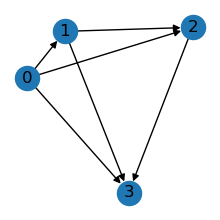

In [61]:
G = nx.empty_graph(0, nx.DiGraph)
G.add_nodes_from(range(E.shape[0]))
G.add_edges_from(edges)
plt.figure(figsize=(2,2)) 
nx.draw(G, with_labels=True)

## Solve initial problem

### Scipy

In [115]:
from scipy.optimize import Bounds, LinearConstraint, minimize

In [98]:
def f(x):
    return x.T @ np.diag(Q) @ x + q.T @ x

In [69]:
bounds = Bounds(np.zeros(n), u)
lin_const = LinearConstraint(E, b, b)

In [107]:
x0 = np.zeros(n)
res = minimize(f, x0, method='trust-constr',
               constraints=lin_const, bounds=bounds,
               options={'verbose': 1})

/opt/anaconda3/envs/cm/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


`xtol` termination condition is satisfied.
Number of iterations: 232, function evaluations: 1603, CG iterations: 304, optimality: 8.77e-05, constraint violation: 1.03e-16, execution time:  1.3 s.


In [116]:
print('x: '+str(res.x))
print('f(x): '+str(f(res.x)))
print('norm(Ex-b): '+str(norm(E@res.x-b)))

x: [1.87838282e+00 2.56073406e+00 5.56088312e+00 1.87584760e-07
 1.87838263e+00 2.56073425e+00]
f(x): 6328.2373522487715
norm(Ex-b): 1.0318010085992092e-16


### CVXPY

In [118]:
import cvxpy as cp

In [136]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, np.diag(Q)) + q.T @ x)
constraints = [0 <= x, x <= u, E@x==b]
prob = cp.Problem(objective, constraints)

In [139]:
res = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Nov 15 12:54:19 PM: Your problem has 6 variables, 3 constraints, and 0 parameters.
(CVXPY) Nov 15 12:54:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 15 12:54:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 15 12:54:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 15 12:54:19 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 15 12:54:19 PM: Finished problem compilation (took 

In [140]:
print('x: '+str(x.value))
print('f(x): '+str(res))
print('norm(Ex-b): '+str(norm(E@x.value-b)))

x: [1.87838269e+00 2.56073395e+00 5.56088335e+00 2.50710231e-16
 1.87838269e+00 2.56073395e+00]
f(x): 6328.237306206148
norm(Ex-b): 1.00571751810586e-14


## CompactSVD

In [226]:
def compactSVD(E):
    m = E.shape[0]
    r = m-1
    # Compute thin SVD
    U, s, Vt = svd(E, full_matrices=False)
    Um = U[:,-1]
    U = U[:, 0:r]
    S = np.diag(s[0:r])
    V = Vt.T[:,0:r]
    
    return U, S, V, Um   

In [227]:
U, S, V, Um = compactSVD(E)

In [228]:
np.allclose(E, U@S@V.T)

True

## getBoxedx

In [232]:
def getBoxedx(Q, q, E, b, u, mu):
    n = Q.shape[0]
    x = np.zeros(n)
    
    for i in range(n):
        if Q[i] == 0:
            if mu.T @ b < q[i]*u[i] + mu.T @ (E[:,i]*u(i) - b):
                x[i] = 0
            else:
                x[i] = u[i]
        else:
            x[i] = (-q[i] - E.T[i,:] @ mu)/(2*Q[i])
            x[i] = max(0, min(x[i], u[i]))
        
    return x

In [233]:
mu = np.zeros(m)

In [235]:
x = getBoxedx(Q, q, E, b, u, mu)

In [236]:
x

array([0., 0., 0., 0., 0., 0.])

## QMCF_solver

In [318]:
eps = 1e-4
l = 6.3282e+03
lambd = 0.5
best_l = False
m = 0.1
max_iter = 50

In [272]:
exitFlag=1
n = E.shape[1]
m = E.shape[0]
U, S, V, Um = compactSVD(E)


# Check satisfiability condition for E*x=b
if np.abs(Um.T @ b) > 1.0e-10:
    print('Ex=b unsatisfiable')
    exitFlag = -1
    

# Initilization of parameters
def f(x):
    return x.T @ np.diag(Q) @ x + q.T @ x

def L(x, mu):
    return f(x) + mu.T @ (E@x - b)

def dualf(x, mu):
    return -L(x, mu)

bar_mu = np.zeros(m)
bar_x = getBoxedx(Q, q, E, b, u, bar_mu)
x_best = []

x_lin_const = V @ pinv(S) @ U.T @ b

In [311]:
# Bundle initialization
z = (E@bar_x)-b
alpha = np.dot(z, bar_mu) - dualf(bar_x, bar_mu)
B_z = z
B_alpha = alpha
X = bar_x

# Initialization of lower bound and upper bound
LB = 0
UB = np.Inf
#LB = L(bar_x, bar_mu)
#UB = f(bar_x)


# Initialization of variable for optimal x
x_sat_const_found = False
num_iterations = 0
theta_case = 0
d = 0

print('iter gap ||theta|| ||bar_mu|| ||bar_x|| l Case ||New z|| New alpha ||d|| step')

iter gap ||theta|| ||bar_mu|| ||bar_x|| l Case ||New z|| New alpha ||d|| step


In [317]:
np.all(np.ones(m)>0.5)

True

In [324]:
len(x_best)

0

In [ ]:
while(np.abs(UB-LB) >= epsilon && num_iterations < max_iter):
    
    #[bar_mu, theta, l, d, steptype] = LBM(dualf, bar_x, bar_mu, l, B_z, B_alpha, lambda, best_l, m_lbm);
    
    # Case 1: theta is a convex combinator, optimal x
    if(np.abs(np.sum(theta)-1) <= eps and np.all((B_z @ theta)<eps)):
        theta_case = 1
        bar_x = X @ theta
        x_sat_const_found = true
    
    # Case 2: try to force x in [0,u] using a Lagrangian heuristic
    else:
        theta_scaled = theta;
        if(np.sum(theta)!=1 and np.sum(theta)!=0):
            theta_scaled = theta/np.sum(theta)
        
        bar_x = X @ theta_scaled
        bar_x = bar_x - V @ V.T @ bar_x + x_lin_const
        
        if (np.all(bar_x >= -eps) and np.all(bar_x <= u+eps)):
            theta_case = 2
            theta = theta_scaled
            x_sat_const_found = true
        
        # Case 3: optimal x not found, find a feasible one
        else:
            theta_case = 3
            bar_x = getBoxedx(Q, q, E, b, u, bar_mu)
    
    
    # Update LB and UB if an optimal x has been found
    if(x_sat_const_found):
        if len(x_best) == 0:
            x_best = bar_x
            UB = f(x_best)
            LB = L(x_best, bar_mu)
        else:
            
            # Update UB and the level parameter
            if (f(bar_x) < f(x_best)):
                x_best = bar_x
                l = f(x_best)
                UB = l
        
        # Update LB
        if(L(bar_x, bar_mu) > LB):
            LB = L(bar_x, bar_mu)
            
        x_sat_const_found=false
    
    X = np.vstack((X,bar_x))
    # Compute new pair (z, alpha) and append to the bundle
    if(np.abs(np.sum(theta)-1) <= eps):
        newz = B_z@theta
        newalpha = B_alpha@theta
    else:
        newz = (E@bar_x)-b
        newalpha = newz.T@bar_mu - dualf(bar_x, bar_mu)
        
    B_z = np.vstack((B_z,newz))
    B_alpha = np.vstack((B_alpha,newalpha))
    num_iterations = num_iterations + 1
    
    
    #print('%d \t %1.1e \t %1.4e \t %1.4e \t %1.4e \t %1.4e \t %d \t %1.4e \t %1.1e \t %1.4e \t %s\n',
    #    num_iterations, norm(UB-LB), norm(theta), norm(bar_mu), norm(bar_x), l, theta_case, norm(newz), newalpha, norm(d), steptype);